## Run FUTURES POTENTIAL submodel  

#### The POTENTIAL submodel ([r.futures.potential](https://grass.osgeo.org/grass82/manuals/addons/r.futures.potential.html)) determines site suitability using a set of coefficients and the probability of past development.  

#### This notebook is used to compute FUTURES POTENTIAL submodel under three scenarios:
- inclusion classic predictors of development (including land cover data, slope, location of roads)
- inclusion of classic predictors and core-district zoning
- inclusion of classic predictors and sub-district zoning

###### Usage note: this script relies on output from FUTURES_preprocessing.ipynb

Initialize GRASS notebook and add required extensions

In [2]:
# Set up GRASS environment
import os
from IPython.display import Image
from helper import show_interactively, show
import grass.script as gs
import csv
# had to add shell = True to helper.py for this to work
from helper import initialize_GRASS_notebook
initialize_GRASS_notebook(binary='grass83',
                          grassdata="D:\\grassdata", location="FUTURES_zoning_prelim",
                          mapset="input")

In [3]:
!g.gui

Set GRASS region and mask to the Central Pines Regional Council

In [2]:
!g.region raster=sa_counties@input res=30
!r.mask raster=sa_counties@input

All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.


In [1]:
core_district = 'dist_to_mixeduse_km,dist_to_nonresidential_km,dist_to_residential_km'
# sub-district zones
sub_district = 'dist_to_downtown_km,dist_to_planned_dev_km,dist_to_commercial_km,dist_to_industrial_km,dist_to_low_den_residential_km,dist_to_high_den_residential_km'
# without zoning
parameters = 'devpressure_2001,slope,road_dens_perc,forest_2001_smooth_perc,ag_2001_smooth_perc,dist_to_water_2001_km,dist_to_wetland_2001_km,dist_to_protected_km,dist_to_city_boundaries_km'
all_parameters = ",".join([parameters, core_district, sub_district])
all_parameters

'devpressure_2001,slope,road_dens_perc,forest_2001_smooth_perc,ag_2001_smooth_perc,dist_to_water_2001_km,dist_to_wetland_2001_km,dist_to_protected_km,dist_to_city_boundaries_km,dist_to_mixeduse_km,dist_to_nonresidential_km,dist_to_residential_km,dist_to_downtown_km,dist_to_planned_dev_km,dist_to_commercial_km,dist_to_industrial_km,dist_to_low_den_residential_km,dist_to_high_den_residential_km'

In [4]:
train_years = [2001, 2004, 2006, 2008, 2011]
validate_years = [2013, 2016, 2019, 2021]
# scenarios
# core district zones
core_district = 'dist_to_mixeduse_km,dist_to_nonresidential_km,dist_to_residential_km'
# sub-district zones
sub_district = 'dist_to_downtown_km,dist_to_planned_dev_km,dist_to_commercial_km,dist_to_industrial_km,dist_to_low_den_residential_km,dist_to_high_den_residential_km'
# without zoning
parameters = 'devpressure_2001,slope,road_dens_perc,forest_2001_smooth_perc,ag_2001_smooth_perc,dist_to_water_2001_km,dist_to_wetland_2001_km,dist_to_protected_km,dist_to_city_boundaries_km'
# with zoning - core
core_parameters = ",".join([parameters, core_district])
# with zoning - sub
sub_parameters = ",".join([parameters, sub_district])
# with core and sub zoning districts
all_parameters = ",".join([parameters, core_district, sub_district])
# development change raster
developed = 'urban_change_01_11'

# subregions
subregion = 'sa_counties'

In [5]:
# Function to get predictors from potential.csv file
# Note: not removing first three columns (ID, Intercept, Devpressure) in this version of the function but do in FUTURES_PGA.ipynb
def get_pred(file_name):
    file = open(file_name)
    csvreader = csv.reader(file)
    pred = []
    pred = next(csvreader)
    file.close()
    return pred

In [6]:
# random_column sets random effect predictor
# fixed_column = 'Predictor columns that will be used for all models when dredging'
# May need to use fixed_column for devpressure?
def potential(potential_file, parameters, nprocs):
    gs.run_command('r.futures.potential', flags='d', input='sampling', nprocs=nprocs,
                output=potential_file, columns=parameters, random_column = 'devpressure_2001',
                developed_column=developed, subregions_column=subregion, min_variables=6)
    return(get_pred(potential_file))

In [7]:
def potential_surface(potential_file, output):
    gs.run_command('r.futures.potsurface', input=potential_file, subregions=subregion, output=output)
    gs.run_command('r.colors', map=output, color='byr')
    return(show(output))

POTENTIAL without zoning

In [7]:
# returns chosen predictors
potential('results\\potential.csv', parameters, 5)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_city_boundaries_km',
 'dist_to_protected_km',
 'forest_2001_smooth_perc',
 'road_dens_perc',
 'slope']

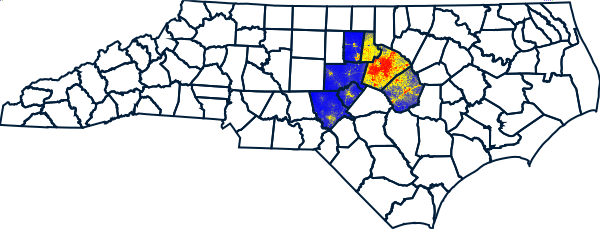

In [8]:
# explore potential surface if interested -- not necessary step
potential_surface('results\\potential.csv', 'suitability')

POTENTIAL with core zoning

In [8]:
potential('results\\potential_core.csv', core_parameters, 5)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_mixeduse_km',
 'dist_to_nonresidential_km',
 'dist_to_water_2001_km',
 'road_dens_perc',
 'slope']

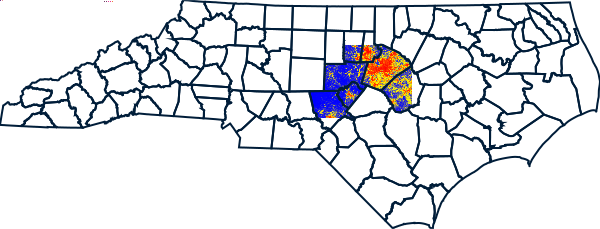

In [10]:
potential_surface('results\\potential_core.csv', 'suitability_core')

POTENTIAL with sub zoning

In [9]:
potential('results\\potential_sub.csv', sub_parameters, 6)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_city_boundaries_km',
 'dist_to_commercial_km',
 'dist_to_planned_dev_km',
 'dist_to_water_2001_km',
 'road_dens_perc',
 'slope']

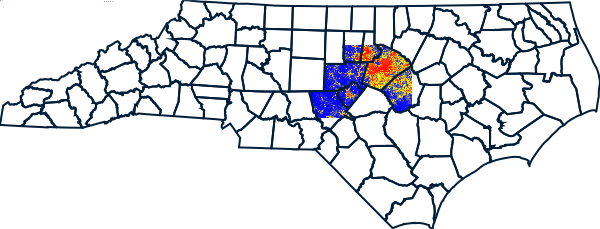

In [11]:
potential_surface('results\\potential_sub.csv', 'suitability_sub')

POTENTIAL given core and sub zoning

In [10]:
potential('results\\potential_all.csv', all_parameters, 5)

KeyboardInterrupt: 

In [ ]:
!r.futures.potential -d input=sampling output=C:\Users\malawrim\Documents\GitHub\FUTURES_zoning_prelim\results\potential_all.csv columns=dist_to_mixeduse_km,dist_to_nonresidential_km,dist_to_residential_km,dist_to_downtown_km,dist_to_planned_dev_km,dist_to_commercial_km,dist_to_industrial_km,dist_to_low_den_residential_km,dist_to_high_den_residential_km,devpressure_2001,slope,road_dens_perc,forest_2001_smooth_perc,ag_2001_smooth_perc,dist_to_water_2001_km,dist_to_wetland_2001_km,dist_to_protected_km,dist_to_city_boundaries_km developed_column=urban_change_01_11 subregions_column=sa_counties random_column=devpressure_2001 nprocs=5

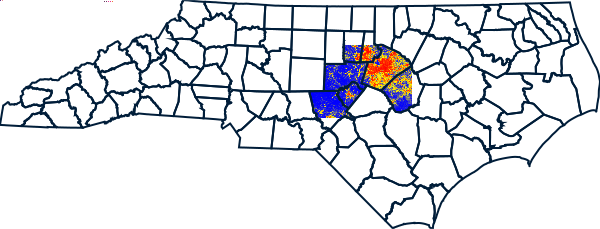

In [12]:
potential_surface('results\\potential_all.csv', 'suitability_all')